## **ICP Tutorial:**

By Derek Benham

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt

(-5.562621661487507,
 6.815054891237646,
 -1.5601946752049485,
 11.387897308015901)

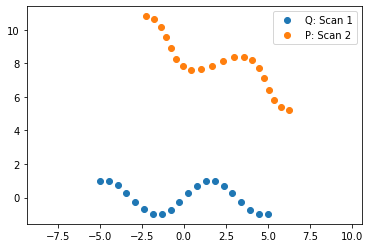

In [3]:
# Generate some data. No noise for now.
x = np.linspace(-5, 5, 20)
y = np.sin(x)
Q = np.vstack((x, y)).T

# Ground Truth Translation and Rotation matrices
theta = np.pi/8
true_rotation = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
true_translation = np.array([2, 8])

P = np.dot(Q, true_rotation) + true_translation

# plot the data
plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1')
plt.plot(P[:,0], P[:,1], 'o', label='P: Scan 2')
plt.legend()
plt.axis('equal')

#### **Step 1: Find Correspondences between scans**

Our first approach for solving ICP will be the least efficient but a proof of concept. As shown in the figure below, the brute force method of finding correspondences grows at N^2

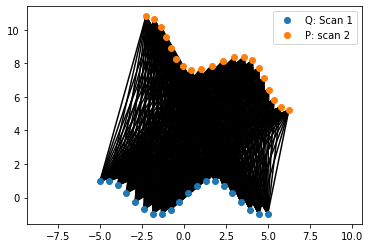

In [4]:
for i in range(Q.shape[0]):
    for j in range(P.shape[0]):
        plt.plot([Q[i,0], P[j,0]], [Q[i,1], P[j,1]], 'k-')
plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1')
plt.plot(P[:,0], P[:,1], 'o', label='P: scan 2')
plt.axis('equal')
plt.legend()

Total correspondence error: 87.63


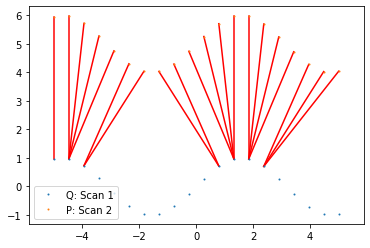

In [42]:
sum_min_correspondence_error = 0

def compute_correspondence(P, Q):
    correspondences = []
    total_dist = 0
    for i in range(P.shape[0]):
        min_dist = np.inf
        for j in range(Q.shape[0]):
            dist = np.linalg.norm(P[i] - Q[j])
            if dist < min_dist:
                min_dist = dist
                min_correspondence_idx = j
        correspondences.append(min_correspondence_idx)
        total_dist += min_dist
        
    return correspondences, total_dist

def plot_correspondence(P, Q, correspondences):
    for i in range(P.shape[0]):
        plt.plot([P[i,0], Q[correspondences[i],0]], [P[i,1], Q[correspondences[i],1]], 'r-')
    plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1', markersize=1)
    plt.plot(P[:,0], P[:,1], 'o', label='P: Scan 2', markersize=1)
    plt.legend()
    plt.axis('equal')

correspondences, sum_error = compute_correspondence(P, Q)
plot_correspondence(P, Q, correspondences)
print("Total correspondence error:", round(sum_error, 2))

#### **Step 2: Center the 2nd Scan**

Centering the data first helps us find local minima, but also helps us find the translation error between the scans (I think)

P center: [[2. 8.]]
Total correspondence error: 19.52


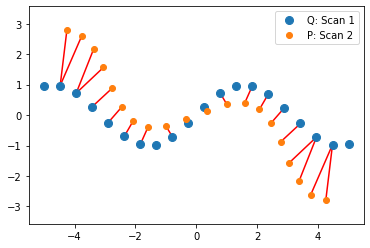

In [6]:
# Data needs to be centered for the ICP algorithm to work
def center_data(data):
    center = np.array([data.mean(axis=0)])
    return center, data - center

center_of_P, P_centered = center_data(P)

correspondences, sum_error = compute_correspondence(P_centered, Q)
plot_correspondence(P_centered, Q, correspondences)
print("P center:", center_of_P)
print("Total correspondence error:", round(sum_error, 2))

#### **Step 3: Computing the Cross Covariance**

Work in progress

$$ K_{PQ} = cov(P,Q) = \mathop{\mathbb{E}}[(P-\mu_{P})(Q-\mu_{Q})^{T} $$

$$ K_{P_{i}Q_{j}} = cov(P_{i},Q_{j}) = \mathop{\mathbb{E}}[(P_{i}-\mathop{\mathbb{E}}[P_{i}])(Q_{j}-\mathop{\mathbb{E}}[Q_{j}]) $$

Note: Because the data is centered at 0, the means are discarded

https://en.wikipedia.org/wiki/Cross-covariance

https://en.wikipedia.org/wiki/Cross-covariance_matrix

$$Inner Product = u^{T}v$$

$$Outer Product = uv^{T}$$

Inner product prudces a scaler, outer product produces a matrix


In [7]:
def compute_cross_covariance(P, Q, correspondences):
    cross_covariance = np.zeros((2,2))
    for i in range(P.shape[0]):
        cross_covariance += np.outer(P[i], Q[correspondences[i]])
    return cross_covariance

cross_covariance = compute_cross_covariance(P_centered, Q, correspondences)
print("Cross covariance matrix:\n", cross_covariance)

Cross covariance matrix:
 [[172.99853708 -17.62309375]
 [-82.5301859   17.85371624]]


With the Cross-Covariance, we will compute its SVD decomposition

$$ SVD(K) = USV^{T}$$

With these equations, the following will be calculated:

$$ R = UV^T $$
$$ t = \mu_{Q}-R\mu_{P} $$

In [8]:
def SVD(Q, P, cross_covariance):
    U, S, V = np.linalg.svd(cross_covariance)
    R = np.dot(U, V.T) 
    center_of_Q = center_data(Q)[0]
    t = (center_of_Q.T - R.T@center_of_P.T).T[0] 
    # R is transposed because indices are flipped col, row
    return R, t

R, t = SVD(Q, center_of_P, cross_covariance)
print("Rotation matrix:\n", R)
print("Translation vector:\n", t)

Rotation matrix:
 [[ 0.94674655  0.32197977]
 [-0.32197977  0.94674655]]
Translation vector:
 [ 0.6823451  -8.21793193]


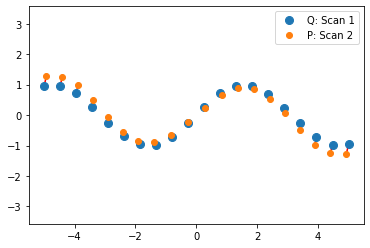

In [9]:
P_adjusted = P@R+t
correspondences, sum_error = compute_correspondence(P_adjusted, Q)
plot_correspondence(P_adjusted, Q, correspondences)

#### **Final Step: Iterative Approach**

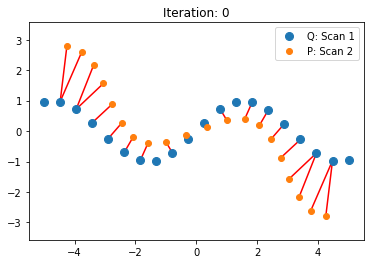

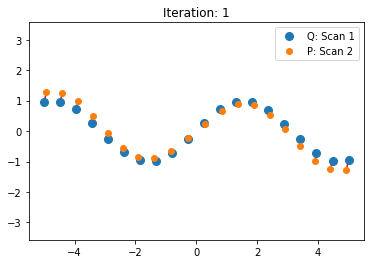

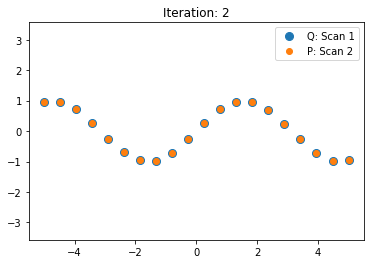

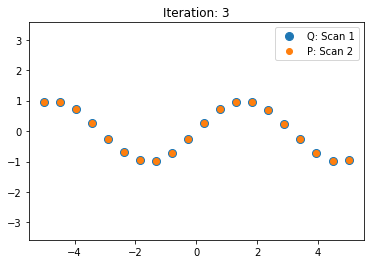

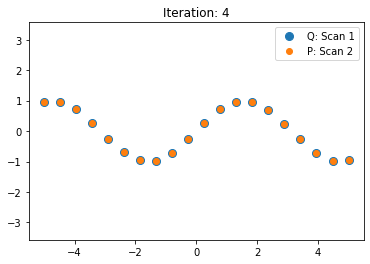

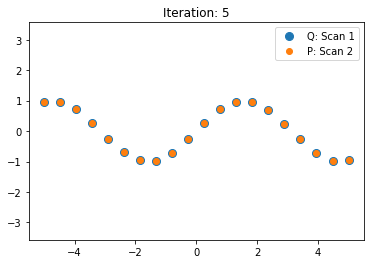

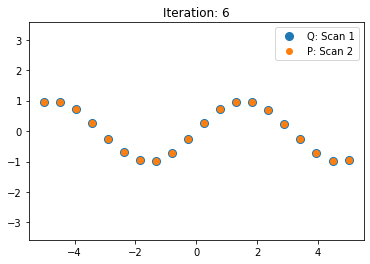

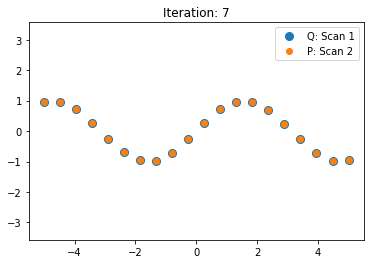

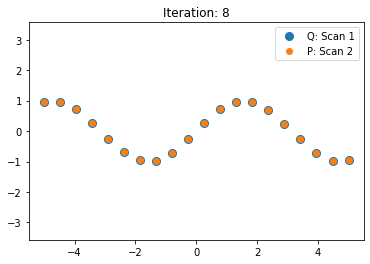

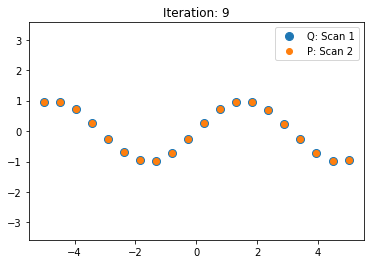

Rotation matrix:
 [[ 1.00000000e+00 -8.32667268e-17]
 [ 8.32667268e-17  1.00000000e+00]]
Translation vector:
 [-2. -8.]
Rotation Matrix Error: 0.551798758565886
Translation Vector Error: 8.881784197001252e-16


In [10]:
def SVD_ICP(Q, P, num_iterations=10, plotting=False):
    loss = []
    center_of_P, P_centered = center_data(P)
    for i in range(num_iterations):
        correspondences, sum_error = compute_correspondence(P_centered, Q)
        if plotting:
            plot_correspondence(P_centered, Q, correspondences)
            plt.title("Iteration: " + str(i))
            plt.show()
        cross_covariance = compute_cross_covariance(P_centered, Q, correspondences)
        R, t = SVD(Q, P_centered, cross_covariance)
        P_centered = P_centered@R+t
        center_of_P, P_centered = center_data(P_centered)
        loss.append(sum_error)

    return R, t, loss

R, t, loss = SVD_ICP(Q, P, num_iterations=10, plotting=True)
print("Rotation matrix:\n", R)
print("Translation vector:\n", t)
print("Rotation Matrix Error:", np.linalg.norm(R - true_rotation))
# t is multiplied by -1 because the translation direction is flipped
print("Translation Vector Error:", np.linalg.norm(t*-1 - true_translation))


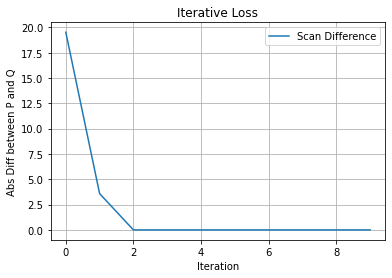

In [11]:
R, t, loss = SVD_ICP(Q, P, num_iterations=10, plotting=False)
plt.plot(loss, label='Scan Difference')
plt.grid()
plt.title("Iterative Loss")
plt.xlabel("Iteration")
plt.ylabel("Abs Diff between P and Q")
plt.legend()

## **Non-Linear Least Squares ICP**

Minimize:
$$ E = \sum_{i}[Rp_{i}+t-q_{i}]^{2} $$

Represent **x** as $[x,y,\theta]^{T}$ for which we will minimize the rotation and translation between P and Q. I will begin by solving it without the Jacobian

In [12]:
# Resetting variables
x = np.linspace(-5, 5, 20)
y = np.sin(x)
Q = np.vstack((x, y)).T

# Ground Truth Translation and Rotation matrices
theta = np.pi/8
true_rotation = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
true_translation = np.array([2, 8])

P = np.dot(Q, true_rotation) + true_translation


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 215
         Function evaluations: 390
[ 1.21366893 -8.15640273 -0.39269317]
8.487785437452156e-09


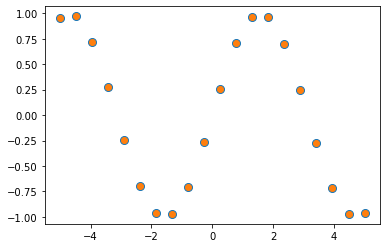

In [13]:
# correspondences, sum_error = compute_correspondence(P_adjusted, Q)

def cost(R, t):
    return np.sum(np.linalg.norm((P@R+t - Q)**2, axis=1))

def icp_least_squares(inputs):
    x = inputs[0]
    y = inputs[1]
    theta = inputs[2]
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    t = np.array([x, y])
    return cost(R, t)

x0 = [0, 0, 0]
res = opt.minimize(icp_least_squares, x0, method='Nelder-Mead', options={'disp': True})    
# res = opt.minimize(icp_least_squares, x0, args=(a,), method='BFGS', jac=jac, options={'disp': True})    

x = res.x[0]
y = res.x[1]
theta = res.x[2]
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
t = np.array([x, y])

adjusted_P = P@R+t
plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1', markersize=8)
plt.plot(adjusted_P[:,0], adjusted_P[:,1], 'o', label='P: Scan 2')
print(res.x)
print(res.fun)



## **Using Point to Point with Least Squares ICP (with Jacobian)**

### **Minimization**

$ \pmb{p}_{i} \in P$ is a point in the point cloud P we are attempting to match with $ \pmb{q}_{i} \in Q$ in the point cloud Q.

To "match" scans we are trying to find the pose $ \pmb{x}=\begin{bmatrix}x & y & \theta\end{bmatrix}^{T} $ that minimizes the error $ \pmb{e}=\begin{bmatrix}e_{x} & e_{y} & e_{\theta}\end{bmatrix}^{T} $ between the two point clouds.

$ \pmb{h}_{i}(\pmb{x}) = \pmb{R}_{\theta} \pmb{p}_{i} + \pmb{t} $
denotes the points from scan P transformed with $\pmb{R}$ and $\pmb{t}$ in an attempt to align with scan Q.

The error function $\pmb{e}$ is defined as:
$$ \pmb{e(x)} = \sum_{i,j\in C} \pmb{e}_{i,j}(\pmb{x}),
$$
where $C$ is the set of correspondences between the two point clouds.

$$ \pmb{e}_{i,j}(\pmb{x}) = \pmb{h}_{i}(\pmb{x}) - \pmb{q}_{j} = \pmb{R}_{\theta}\pmb{p}_{i}+\pmb{t}-\pmb{q}_{j}$$

This allows us to fromulate the minimization problem as:
$$ \pmb{x}_{query} = \arg\min_{\pmb{x}} \pmb{E(x)}
\\
= \arg\min_{\pmb{x}} \sum_{i,j\in C} \|\pmb{e}_{i,j}(\pmb{x}) \|^{2}
\\
= \argmin_{\pmb{x}} \sum_{i,j\in C} \| \pmb{h}_{i}\pmb{x} - \pmb{q}_{j} \|^{2}
\\
= \argmin_{\pmb{x}} \sum_{i,j\in C} \| (\pmb{R}_{\theta}\pmb{p}_{i}+\pmb{t}-\pmb{q}_{j}) \|^{2}
$$


### **Gauss Newton Method**

The Gauss Newton method is an iterative method for solving non-linear least squares problems. It is a first order approximation of the non-linear least squares problem. The Gauss Newton method utilizes the Hessian matrix to linearlize the non-linear least squares problem around the point $\pmb{x}$ so we can perform calculus on it. 
The Hessian matrix is the second order derivative of the error function. Solving non-linear least squares is equivalent to solving the following system of equations:
$$ \pmb{H}\Delta\pmb{x} = -\pmb{E}^{'}(\pmb{x})$$
where $\Delta\pmb{x}$ is the incremental of the argument $\begin{bmatrix}\Delta x & \Delta y & \Delta \theta\end{bmatrix}^{T}. \pmb{H}$ is the Hessian of $\pmb{E}$ and $\pmb{E}^{'}(\pmb{x}) is the derivative over the function we are trying to minimize.

$\pmb{E}^{'}(\pmb{x})$ is the gradient of the error function computed as:
$$ \pmb{E}^{'}(\pmb{x}) = \pmb{J}(\pmb{x})\pmb{e}(\pmb{x}) $$

In Gausee-Newton moethod we linearlize the function around the considered point, which allows the Hessian to be computed as $\pmb{H} = \pmb{J}(\pmb{x})^{T}\pmb{J}(\pmb{x})$.

The Hessian matrix is the second order partial derivatives of a scalar valued function. It follows that if you minimize the negative log-likelihood, the returned Hessian is the equivalent of the observed Fisher information matrix. The FIM is the $J^{T}J$ of the Jacobian matrix $J$.

### **The Jacobian is as follows:** ###

$$ \pmb{J} = \frac{\partial{\pmb{e}_{i,j}}{(\pmb{x})}}{\partial{\pmb{x}}} = 
\frac{\partial{\pmb{h}_{i}}{(\pmb{x})}}{\partial{\pmb{x}}} = 
(\frac{\partial{\pmb{h}_{i}}{(\pmb{x})}}{\partial{\pmb{x}}},
\frac{\partial{\pmb{h}_{i}}{(\pmb{x})}}{\partial{\pmb{y}}},
\frac{\partial{\pmb{h}_{i}}{(\pmb{x})}}{\partial{\pmb{\theta}}})
$$ 

$$ = (\pmb{I,R^{'}_{\theta}p_{i}}) $$

$$ = \begin{bmatrix}
1 & 0 & -p_{x}sin(\theta)-p_{y}cos(\theta) \\
0 & 1 & p_{x}cos(\theta)-p_{y}sin(\theta)
\end{bmatrix}$$

Note: The partial of x and y with respect to x is the identity matrix based on the translation matrix, where the partial with respect to $\theta$ is the rotation matrix.

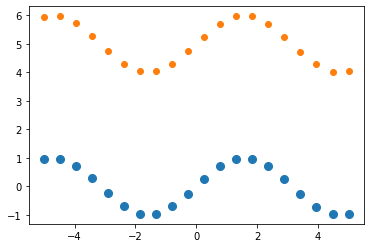

In [38]:
import math
# Resetting variables
x = np.linspace(-5, 5, 20)
y = np.sin(x)
Q = np.vstack((x, y)).T

# Ground Truth Translation and Rotation matrices
theta = 0 #np.pi/8
true_rotation = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
true_translation = np.array([0, 5])

P = np.dot(Q, true_rotation) + true_translation
plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1', markersize=8)
plt.plot(P[:,0], P[:,1], 'o', label='P: Scan 2')

### **Solving Least Squares ICP with Gauss Newton** ###

We will begin by initializing the Hessian $\pmb{H}$ and the gradient $\pmb{g}$ to zero. 

$$ \pmb{H} = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix}, \pmb{g}=\begin{bmatrix} 0 \\ 0 \\ 0\end{bmatrix} $$

We will then iterate over the correspondences between the two point clouds and update the Hessian and gradient. 

$$ \pmb{H} = \pmb{H} + \pmb{J}^{T}\pmb{J} $$
$$ \pmb{g} = \pmb{g} + \pmb{J}^{T}\pmb{e} $$

We will then solve the system of equations $\pmb{H}\Delta\pmb{x} = -\pmb{g} \Longrightarrow \Delta\pmb{x} = -\pmb{H}^{-1}\pmb{g}$ to obtain the incremental pose $\Delta\pmb{x}$. We will then update the pose $\pmb{x}$ with the incremental pose $\Delta\pmb{x}$.
Note: This can be done without inverting the matrix, we'll use np.linalg.lstsq to solve the system of equations.

In [15]:
def dR(theta):
    return np.array([[-np.sin(theta), -np.cos(theta)], [np.cos(theta), -np.sin(theta)]])
def R_matrix(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def jac(x, p_point):
    theta = x[2]
    J = np.zeros((2,3))
    J[0:2, 0:2] = np.eye(2)
    J[0, 2] = -p_point[0]*np.sin(theta) - p_point[1]*np.cos(theta)
    J[1, 2] = p_point[0]*np.cos(theta) - p_point[1]*np.sin(theta)
    return J

def error(x, p_point, q_point):
    theta = x[2]
    rotation = R_matrix(theta)
    translation = x[0:2]
    prediction = rotation.dot(p_point.reshape(2,1)).T[0] + translation
    return prediction.T - q_point

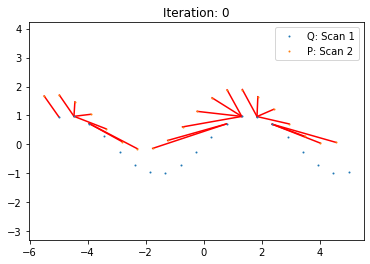

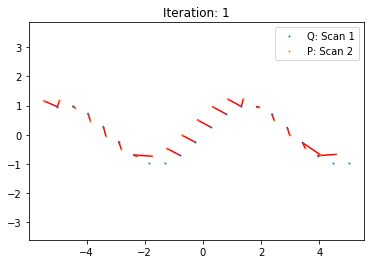

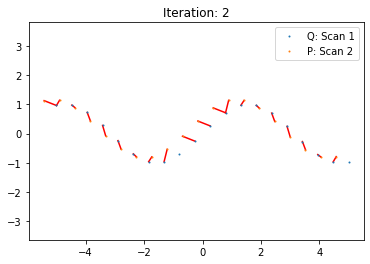

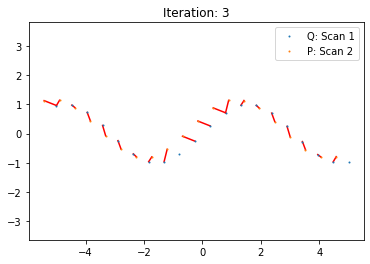

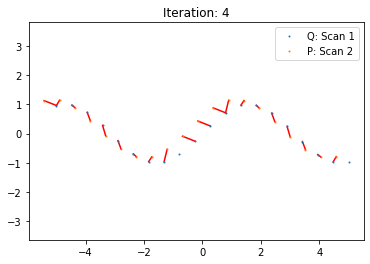

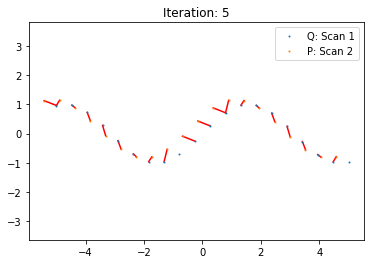

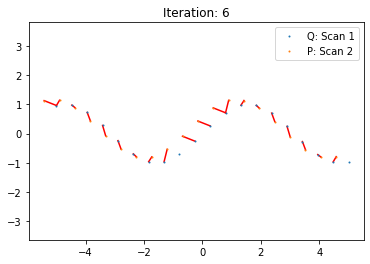

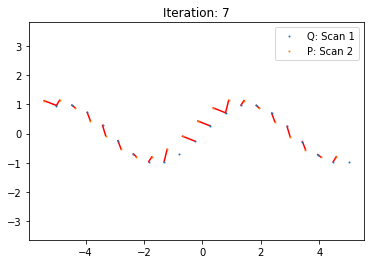

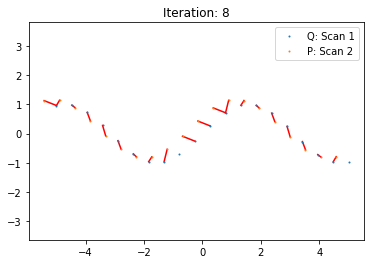

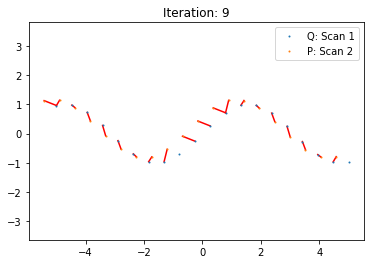

[387.517193691548, 11.511543754540515, 2.2108009588275346, 2.0788019207310717, 2.0787980030563546, 2.0787980022151187, 2.0787980022149086, 2.0787980022149077, 2.078798002214908, 2.0787980022149086]


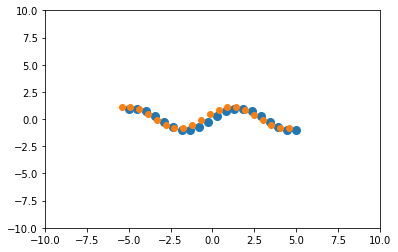

In [43]:
# Thoughts on how to fix my issue. I'm messing up somewhere with the P and P_copy and I'm updating the wrong values

def iterate_icp_least_squares(inputs, p_points, q_points, correspondences):
    H = np.zeros((3,3))
    g = np.zeros((3,1))
    chi = 0
    for i in range(len(correspondences)):
        p_point = p_points[i]
        q_point = q_points[correspondences[i]]
        e = error(inputs, p_point, q_point).T
        J = jac(inputs, p_point)
        H += J.T.dot(J)
        g += np.reshape((J.T.dot(e)), (3,1))
        chi += e.T.dot(e)
    return H, g, chi

def icp_least_squares(P, Q, iterations):
    x = np.zeros((3)) # x, y, theta
    chi_values = []
    x_values = [x.copy()] # adding first value to array
    P_values = [P.copy()] # adding first value to array
    P_copy = P.copy() # copy of P to be used in the loop
    correp_values = []
    for i in range(iterations):
        rot = R_matrix(x[2])
        t = x[0:2]
        correspondences, sum_error = compute_correspondence(P_copy, Q)
        correp_values.append(correspondences)
        H, g, chi = iterate_icp_least_squares(x, P, Q, correspondences)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x = np.reshape(x + dx.T, (3))
        x[2] = math.atan2(np.sin(x[2]), np.cos(x[2])) # Normalize theta
        
        rot = R_matrix(x[2])
        t = x[0:2]
        # Fix me, needto add t to all points in P
        P_copy = (rot.dot(P.T.copy())).T + t # Update P with new rotation and translation
        
        # P_copy[:,0] += t[0]
        # P_copy[:,1] += t[1]
        chi_values.append(chi) # Append chi value to track error
        
        x_values.append(x.copy())
        P_values.append(P_copy)

        plot_correspondence(P_copy, Q, correspondences)
        plt.title("Iteration: " + str(i))
        plt.show()
        # plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1', markersize=8)
        # plt.plot(P_copy[:,0], P_copy[:,1], 'o', label='P: Scan 2')
        # plt.xlim(-10, 10)
        # plt.ylim(-10, 10)
        # plt.show()

    correp_values.append(correp_values[-1]) # don't understand this line
    return x_values, P_values[-1], chi_values, correp_values

x_values, P_values, chi_values, correp_values = icp_least_squares(P, Q, iterations=10)
print(chi_values)

plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1', markersize=8)
plt.plot(P_values[:,0], P_values[:,1], 'o', label='P: Scan 2')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

In [149]:
from matplotlib import animation, rc

def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    y_q = Q[:,0]
    x_q = Q[:,1]
    # draw initial correspondeces
    corresp_lines = []
    for i in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        # draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

animate_results(P_values, Q, correp_values, xlim=(-10, 10), ylim=(-10, 10))

NameError: name 'HTML' is not defined

## **Using Point to plane with Least Squares ICP**

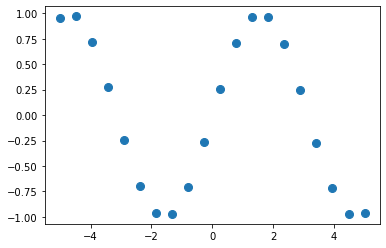

In [35]:
# Refreshing all variables
x = np.linspace(-5, 5, 20)
y = np.sin(x)
Q = np.vstack((x, y)).T

# Ground Truth Translation and Rotation matrices
theta = np.pi/8
true_rotation = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
true_translation = np.array([2, 8])

P = np.dot(Q, true_rotation) + true_translation
plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1', markersize=8)

The normal in the 2D case: $v = [x,y]^{T}$ is $n_{v} = [-y,x]^{T}$

(20, 2)


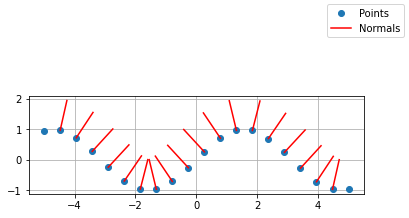

In [33]:
print(Q.shape)
def compute_normals(points, step=1):
    normals = np.zeros((points.shape[0], 2))
    for i in range(step, points.shape[0]-step):
        prev_point = points[i-step]
        curr_point = points[i]
        next_point = points[i+step]
        dx = next_point[0] - prev_point[0]
        dy = next_point[1] - prev_point[1]
        n_v = np.array([-dy, dx])
        n_v = n_v/np.linalg.norm(n_v)
        normals[i] = curr_point + n_v
    return normals

def plot_normals(points, normals, step=1):
    fig, ax =plt.subplots()
    ax.plot(points[:,0], points[:,1], 'o', label='Points')
    for i in range(step, normals.shape[0]-step):
        if i==step:
            ax.plot([points[i,0], normals[i,0]], [points[i,1], normals[i,1]], 'r-', label='Normals')
        else:
            ax.plot([points[i,0], normals[i,0]], [points[i,1], normals[i,1]], 'r-')
    # plt.plot(normals[:,0], normals[:,1], label='Normals')
    ax.grid()
    ax.set_aspect('equal')
    fig.legend()
    plt.show()

normals = compute_normals(Q, step=1)
plot_normals(Q, normals)


The point to plane minimization function is similar to the point to point with one additional variable.

Minimize:
$$ E = \sum_{i}(n_{i}*(R_{\theta}p_{i}+t-q_{i}))^{2} $$

Where $n_{i}$ is the normal of the point $q_{i}$. The new jacobian will now be a $1\times3$ matrix instead of a $2\times3$ matrix.

Point to point Jacobian:
$$\begin{bmatrix}
1 & 0 & -p_{x}sin(\theta)-p_{y}cos(\theta) \\
0 & 1 & p_{x}cos(\theta)-p_{y}sin(\theta)
\end{bmatrix}$$


Point to plane Jacobian:
$$\begin{bmatrix}
n_{x} & n_{y} & n_{x}(p_{x}sin(\theta)-p_{y}cos(\theta)) + n_{y}(p_{x}cos(\theta)-p_{y}sin(\theta))
\end{bmatrix}
$$

In [ ]:
def plane_jac(x, p_point):
    J = np.zeros((3,4))
    J[0:3, 0:3] = np.eye(3)
    J[0:3, [3]] = p_point
    return J